# Determine Data Mapping Accuracy

#### Updated: Jan 26, 2023 by Ashley Ferreira

The purpose of this notebook is to determine the accuracy with which earlier notebooks are able to map the true values from the ionogram images to numpy arrays. This is done by following the steps:
1. Randomly load in a set of ionogram images
2. TBC
3. TBC
4. Use variance to estimate data mapping accuracy for the entire set of images, as well as potentially flag if there are certain directories or cases which have significantly better or significantly worse accuracies.

For now, it repeats much of the code found in notebook 01 and 08 just to get started.

#### Import libraries and set global variables

In [3]:
import pandas as pd
import numpy as np
import os
import random
from random import randrange
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [8]:
resultDir = 'L:/DATA/Alouette_I/BATCH_I_Run1/05_result/'
imageDir = 'L:/DATA/Alouette_I/BATCH_I_Run1/04_processed/'
logDir = 'L:/DATA/Alouette_I/BATCH_I_Run1/06_log/'

In [15]:
sample_size = 5

#### Initialize functions
Cell collapsed for now as it is just direct copy from notebook 08

In [16]:
def inspect_ionograms(roll, subdirectory, sample_list, imageDir, resultDir):
    
    mapped_coords_list = os.listdir(resultDir + 'mapped_coords/' + roll + '/' + subdirectory + '/')
    df_result = pd.read_csv(resultDir + roll + '/result-' + roll + '_' + subdirectory + '.csv')
    
    for image_fn in sample_list:
        print(image_fn)
        image_fn_ = image_fn.replace('.png', '')

        f, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1,1.2],}, figsize=(20,5))

        for mapped_coord_fn in mapped_coords_list:
            if '_' + image_fn_ + '.npy' in mapped_coord_fn:
                print(mapped_coord_fn)
                arr_load = np.load(resultDir + 'mapped_coords/' + roll + '/' + subdirectory + '/' + mapped_coord_fn)
                print(arr_load.shape)

                df_plot = pd.DataFrame({
                'f': arr_load[:, 0],
                'depth': arr_load[:, 1]
                })
                df_plot['depth_plot'] = -1*df_plot['depth']

                axs[0].scatter(df_plot['f'], df_plot['depth_plot'], 1, color='black')
                axs[0].set(xlabel='frequency (MHz)', ylabel='depth (km)')

        img = mpimg.imread(imageDir + roll + '/' + subdirectory + '/' + image_fn)
        axs[1].imshow(img)
        axs[1].set(xticks=[], yticks=[])
        
        #Results
        df_result_img = df_result.loc[df_result['filename'] == image_fn]
        
        plt.show()
        print(df_result_img['processed_image_class'].iloc[0])
        print(df_result_img['Station Name'].iloc[0])
        if df_result_img['processed_image_class'].iloc[0] == 'loss':
            print(df_result_img['func_name'].iloc[0])
        elif df_result_img['processed_image_class'].iloc[0] == 'outlier':
            print(df_result_img['func_name'].iloc[0])
        print('')
        print('')

#### Read in log

In [17]:
df_process_log = pd.read_csv(logDir + 'process_log.csv')
print('number of processed ionograms (i think):', len(df_process_log))
subdir_ids_list = df_process_log['subdir_id'].unique()
df_process_log.head()

number of processed ionograms (i think): 3138


,Roll,Subdirectory,Images_processed,Images_dot,Images_num,Images_loss,Images_outlier,Process_time,Process_timestamp,User,subdir_id
0,R014207978F,319,239,206,5,11,17,259.625649,2022-12-15 23:28:15.951151,Rav,R014207978F_319
1,R014207966,1185-1B,386,0,383,0,3,1415.449691,2022-12-15 23:51:57.608703,Rav,R014207966_1185-1B
2,R014207975,1108-B,363,0,347,4,12,367.330205,2022-12-15 23:58:19.342118,Rav,R014207975_1108-B
3,R014207957,2631-1A,333,0,320,4,9,607.819416,2022-12-16 00:08:43.220755,Rav,R014207957_2631-1A
4,R014207966,1150-B,369,0,362,1,6,775.810147,2022-12-16 00:21:52.993215,Rav,R014207966_1150-B


#### Randomly select 1 subdirectory ID

In [18]:
subdir_id = subdir_ids_list[randrange(len(subdir_ids_list))]
parts = subdir_id.split('_')
roll = parts[0]
subdirectory = parts[1]
print('roll:', roll)
print('subdir:', subdirectory)

roll: R014207980
subdir: 984-B


#### Randomly sample ionogram images
From the subdirectory selected in the previous code block, randomly sample a number of images specified by the sample_size variable.

In [11]:
images_list = os.listdir(imageDir + roll + '/' + subdirectory + '/')
sample_list = random.sample(images_list, sample_size)
print('selected ionogram images:', sample_list)

['256.png', '45.png', '148.png', '310.png', '19.png']

#### Display sampled images

256.png
mapped_coords-R014207956_2396-1B_256.npy
(91141, 2)


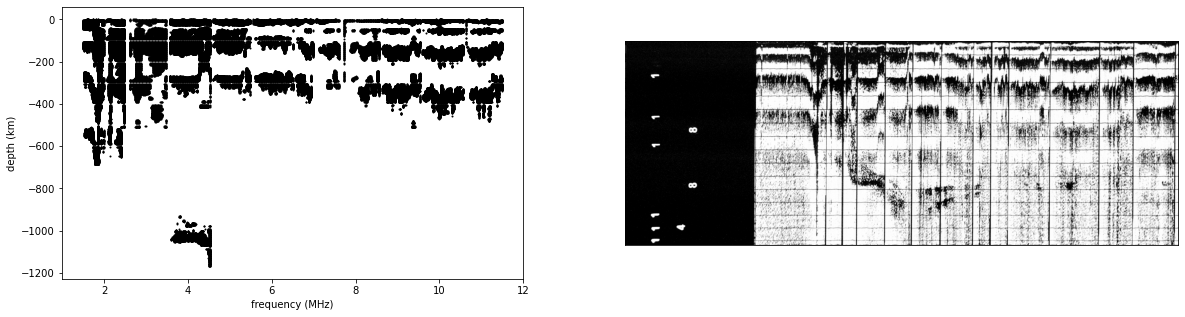

num
Blossom Point, Maryland


45.png
mapped_coords-R014207956_2396-1B_45.npy
(70807, 2)


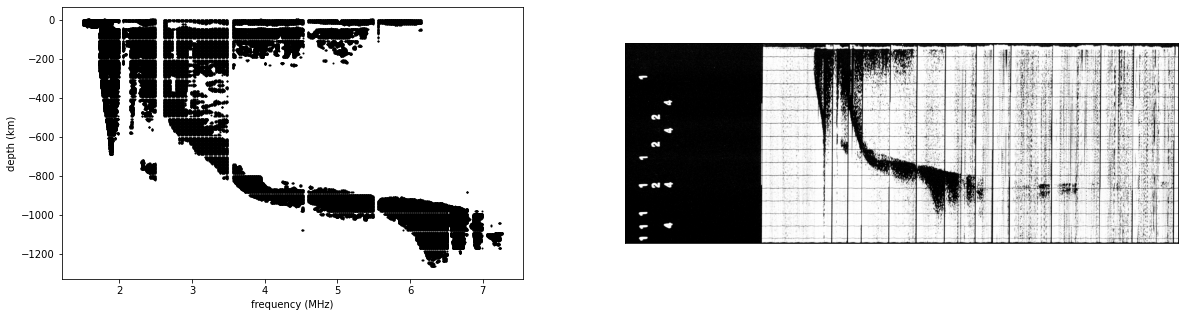

num
Blossom Point, Maryland


148.png
mapped_coords-R014207956_2396-1B_148.npy
(50132, 2)


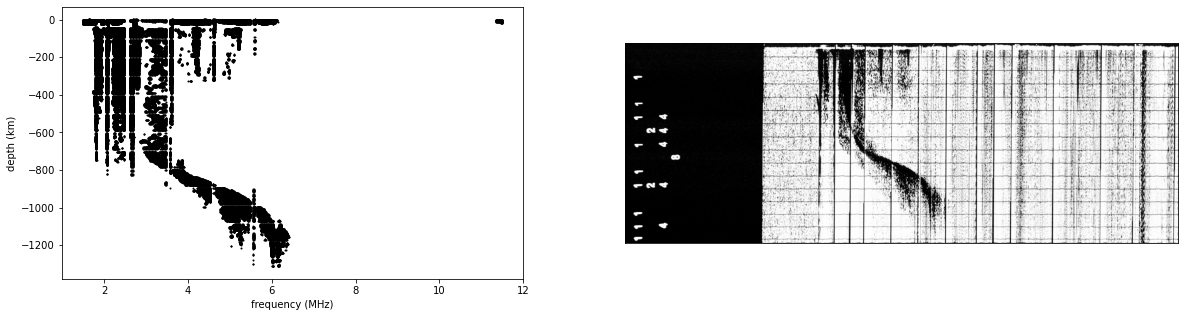

num
Blossom Point, Maryland


310.png
mapped_coords-R014207956_2396-1B_310.npy
(46650, 2)


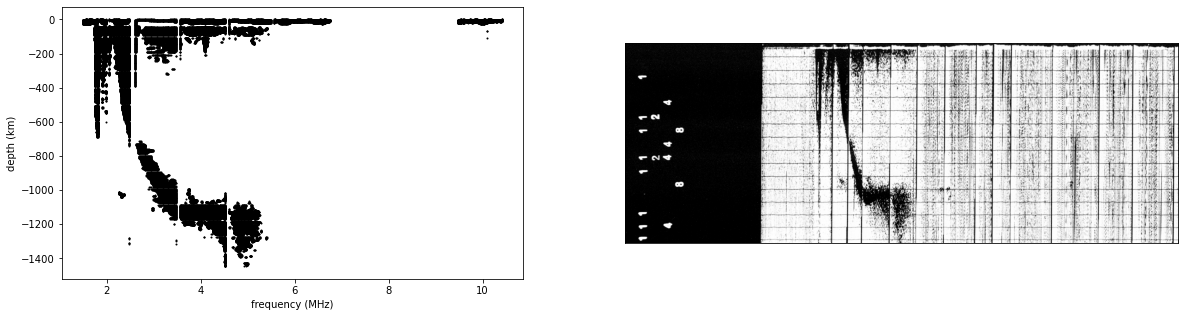

num
Blossom Point, Maryland


19.png
mapped_coords-R014207956_2396-1B_19.npy
(47999, 2)


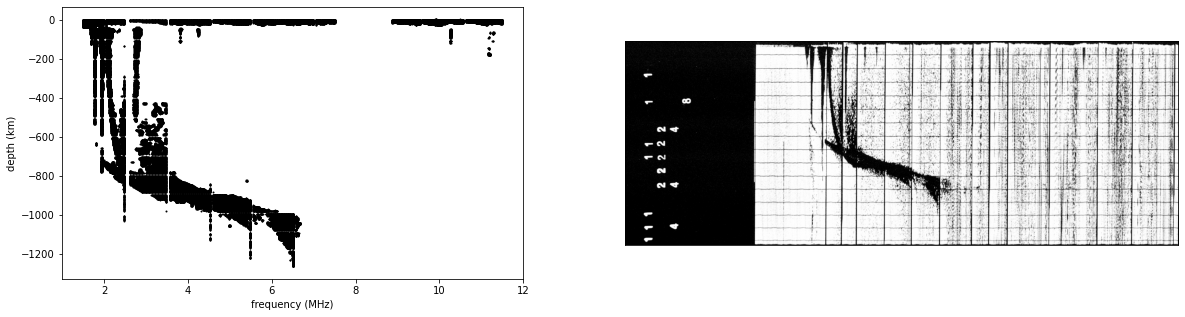

num
Blossom Point, Maryland




In [12]:
inspect_ionograms(roll=roll, subdirectory=subdirectory, sample_list=sample_list, imageDir=imageDir, resultDir=resultDir)